In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-customers/BankChurners.csv


In [2]:
# necessary package
from collections import Counter
from scipy import stats

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import imblearn

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('tableau-colorblind10')
import seaborn as sns
from plotnine import *
import plotly.graph_objects as go
import plotly.express as px

## Load Data

In [3]:
df = pd.read_csv('/kaggle/input/credit-card-customers/BankChurners.csv')
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

In [5]:
len(df['CLIENTNUM'].unique())

10127

## Dataprep

In [6]:
# Correcting Data Type
## string 



In [7]:
# drop columns
df = df.drop(columns = ['CLIENTNUM', 
              'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 
             'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

## Exploration


In [8]:
# Data Distribution + Sample Selection

cat_col = [x for x in df.columns if df[x].dtype == 'O']
num_col = [x for x in df.columns if x not in cat_col]

print('cat_col : {} \n\
num_col : {}'.format(len(cat_col), len(num_col)))

cat_col : 6 
num_col : 14


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator


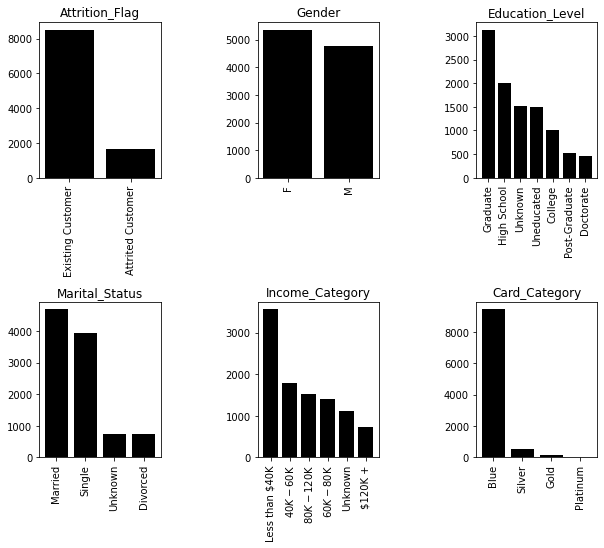

In [9]:
## categorical data
# var = 'Gender'
# tmp = df[var].value_counts().reset_index()
# plt.bar(tmp['index'], tmp[var])
# plt.title(var)

fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(hspace=0.8, wspace=0.8)
for i,var in enumerate(cat_col):
    tmp = df[var].value_counts().reset_index()
    ax = fig.add_subplot(2, 3, i+1)
    ax.bar(tmp['index'], tmp[var], color='black')
    ax.set_title(var)
    ax.set_xticklabels(tmp['index'], rotation=90)


In [10]:
# df['Attrition_Flag'].value_counts()
1627/(1627+8500)

0.1606596227905599

In [11]:
query = (df['Education_Level'] == 'Unknown') 
df[query]['Attrition_Flag'].value_counts()

Existing Customer    1263
Attrited Customer     256
Name: Attrition_Flag, dtype: int64

In [12]:
# df['Marital_Status'].value_counts()
# 749/10127
query = (df['Marital_Status'] == 'Unknown') 
df[query]['Attrition_Flag'].value_counts()

Existing Customer    620
Attrited Customer    129
Name: Attrition_Flag, dtype: int64

In [13]:
query = (df['Income_Category'] == 'Unknown') 
df[query]['Attrition_Flag'].value_counts()

Existing Customer    925
Attrited Customer    187
Name: Attrition_Flag, dtype: int64

In [14]:
# df.groupby(['Card_Category'])['Attrition_Flag'].value_counts()
df['Card_Category'].value_counts()
# 9436/10127

Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64

Note
* imbalance data (Attrited Customer 16.00%)
* Unknown data (Education_Level, Marital_Status, Income_Category)
* Blue Card almost entire data sets

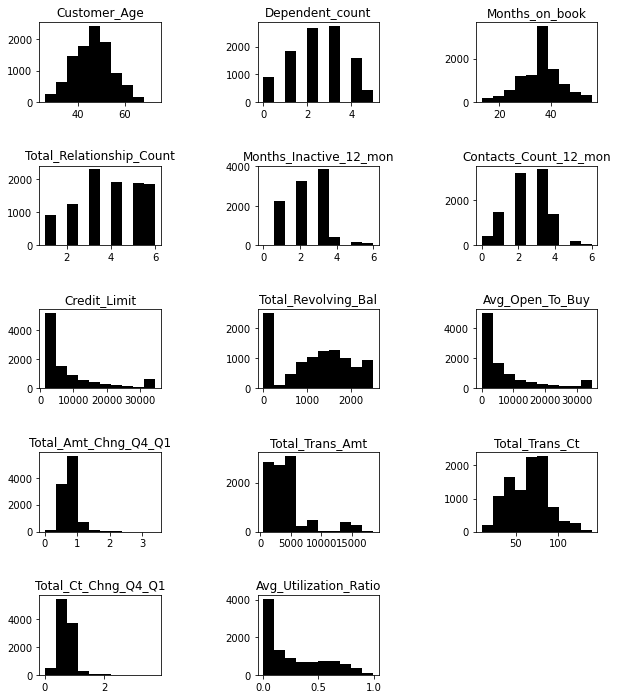

In [15]:
# numerical data
# var = 'Customer_Age'
# tmp = df[var].value_counts().reset_index()
# plt.hist(df[var], color='black')
# plt.title(var)

fig = plt.figure(figsize=(10, 12))
fig.subplots_adjust(hspace=0.8, wspace=0.8)
for i,var in enumerate(num_col):
    ax = fig.add_subplot(5, 3, i+1)
    ax.hist(df[var], color='black')
    ax.set_title(var)

In [16]:
# fig.savefig('./fig2.png')

In [17]:
# Avg_Utilization_Ratio เท่ากับ 0 นี่คือไม่ใช้บัตรเลยหรอ แล้วเปิดทำไม หรือเพิ่งสมัคร ?? 
df[df['Avg_Utilization_Ratio'] == 0]['Months_on_book'].sort_values()

1916    13
1488    13
2284    13
2162    13
2180    13
        ..
3931    56
3784    56
1830    56
4066    56
4331    56
Name: Months_on_book, Length: 2470, dtype: int64

In [18]:
len(num_col) 

14

<AxesSubplot:>

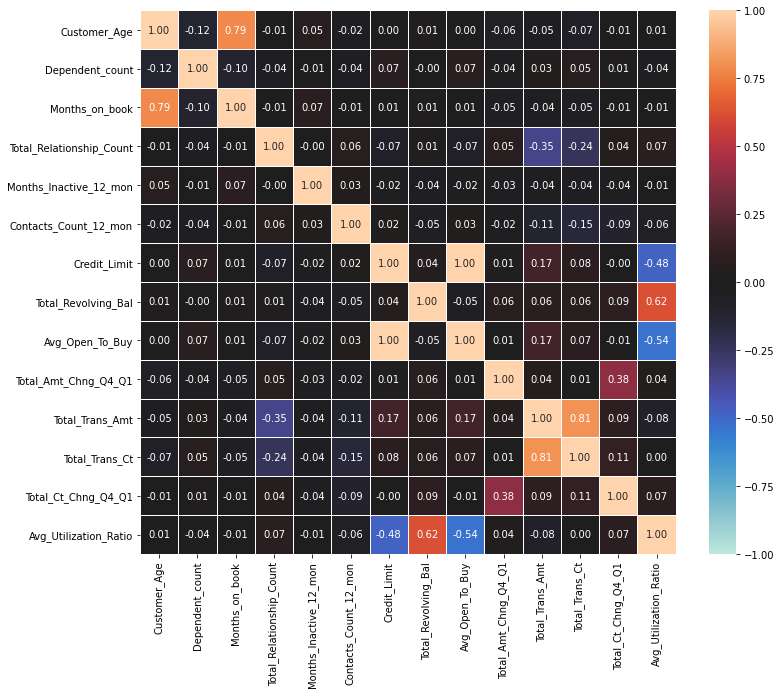

In [19]:
## Relationship between 2 variables
plt.figure(figsize=(12,10))
sns.heatmap(df[num_col].corr(), vmin=-1.0, vmax=1.0, linewidths=0.5, cmap='icefire', annot=True, fmt='.2f')
# plt.savefig

In [20]:
df[num_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              10127 non-null  int64  
 1   Dependent_count           10127 non-null  int64  
 2   Months_on_book            10127 non-null  int64  
 3   Total_Relationship_Count  10127 non-null  int64  
 4   Months_Inactive_12_mon    10127 non-null  int64  
 5   Contacts_Count_12_mon     10127 non-null  int64  
 6   Credit_Limit              10127 non-null  float64
 7   Total_Revolving_Bal       10127 non-null  int64  
 8   Avg_Open_To_Buy           10127 non-null  float64
 9   Total_Amt_Chng_Q4_Q1      10127 non-null  float64
 10  Total_Trans_Amt           10127 non-null  int64  
 11  Total_Trans_Ct            10127 non-null  int64  
 12  Total_Ct_Chng_Q4_Q1       10127 non-null  float64
 13  Avg_Utilization_Ratio     10127 non-null  float64
dtypes: flo

In [21]:
# Sample Selection 
## Marital_Status == 'Unknown'
# df = df[df['Marital_Status'] != 'Unknown']

## Customer Profile

In [22]:
df = pd.read_csv('/kaggle/input/credit-card-customers/BankChurners.csv')
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [23]:
# define features types
demog_features = ['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 
                 'Marital_Status', 'Income_Category']

relate_features = ['Card_Category', 'Months_on_book', 'Total_Relationship_Count', 
                     'Credit_Limit']

behavior_features = ['Months_Inactive_12_mon', 'Contacts_Count_12_mon', 
                     'Total_Revolving_Bal', 'Avg_Open_To_Buy', 
                    'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 
                    'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']



In [24]:
# segmentation : clustering customers by their Demographic and Relationship with Bank
segment_frame = df[['CLIENTNUM'] + demog_features + relate_features]

# retrieve data for clustering 
cat_var = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 
          'Card_Category']
num_var = [x for x in segment_frame.columns.tolist() if x not in cat_var + ['CLIENTNUM']]

X_num = segment_frame[num_var].values
enc = OneHotEncoder()
X_cat = enc.fit_transform(segment_frame[cat_var]).toarray()
X = np.concatenate((X_num, X_cat), axis=1)

print(X.shape)

(10127, 28)


In [25]:
X[:, 4:]

array([[1.2691e+04, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [8.2560e+03, 1.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.4180e+03, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [5.4090e+03, 1.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [5.2810e+03, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0388e+04, 1.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00]])

Automatically created module for IPython interactive environment
For n_clusters = 3 The average silhouette_score is : 0.7008238588786561
For n_clusters = 4 The average silhouette_score is : 0.6769507454292636
For n_clusters = 5 The average silhouette_score is : 0.6521492459452108


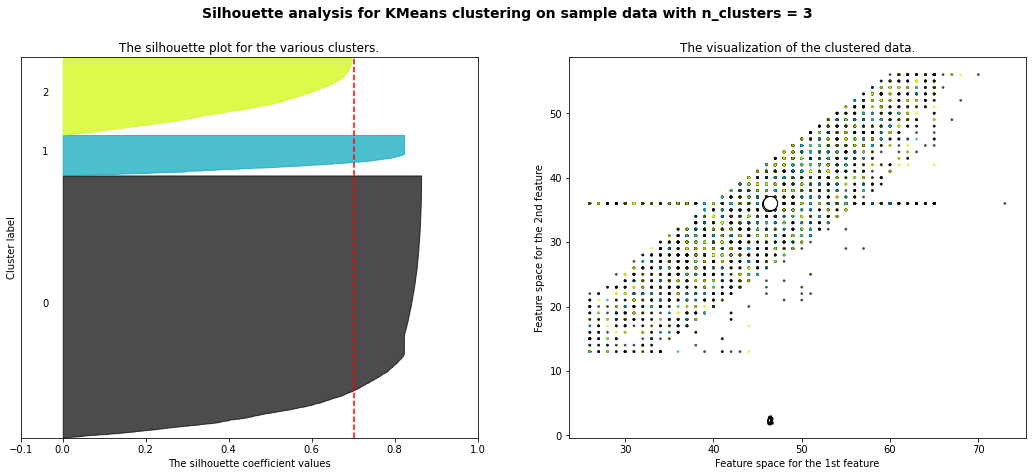

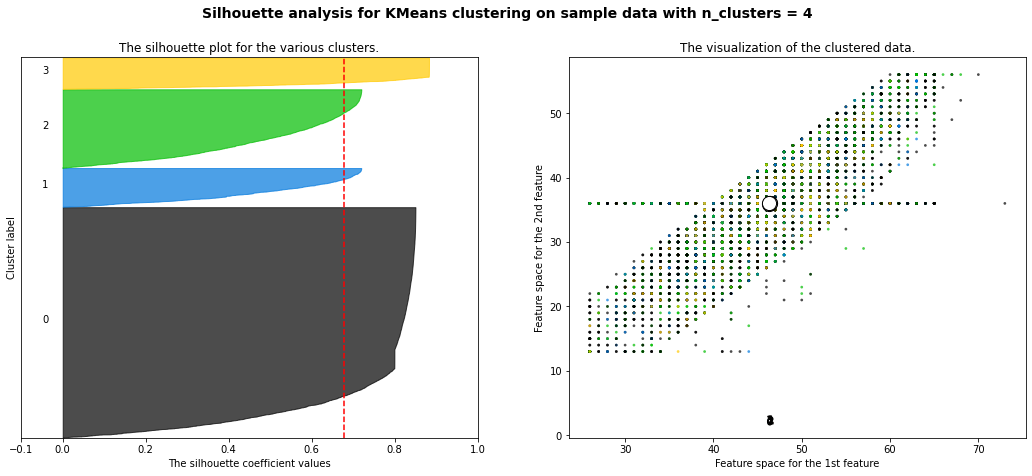

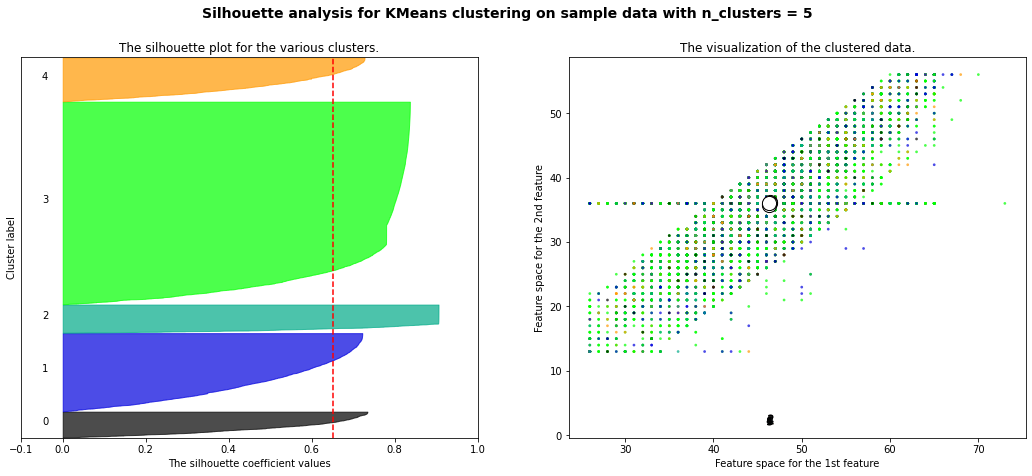

In [26]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
# X =  

range_n_clusters = [3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [27]:
# selected k (k=4)
clusterer = KMeans(n_clusters=3, random_state=10)
cluster_labels = clusterer.fit_predict(X)



In [28]:
segment_frame['customer_group'] = cluster_labels
segment_frame

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Credit_Limit,customer_group
0,768805383,45,M,3,High School,Married,$60K - $80K,Blue,39,5,12691.0,2
1,818770008,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,8256.0,0
2,713982108,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,3418.0,0
3,769911858,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,3313.0,0
4,709106358,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,4716.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,4003.0,0
10123,710638233,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,4277.0,0
10124,716506083,44,F,1,High School,Married,Less than $40K,Blue,36,5,5409.0,0
10125,717406983,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,5281.0,0


In [29]:
# demog + relate by group
segment_frame['customer_group'].value_counts()

0    7001
2    2056
1    1070
Name: customer_group, dtype: int64

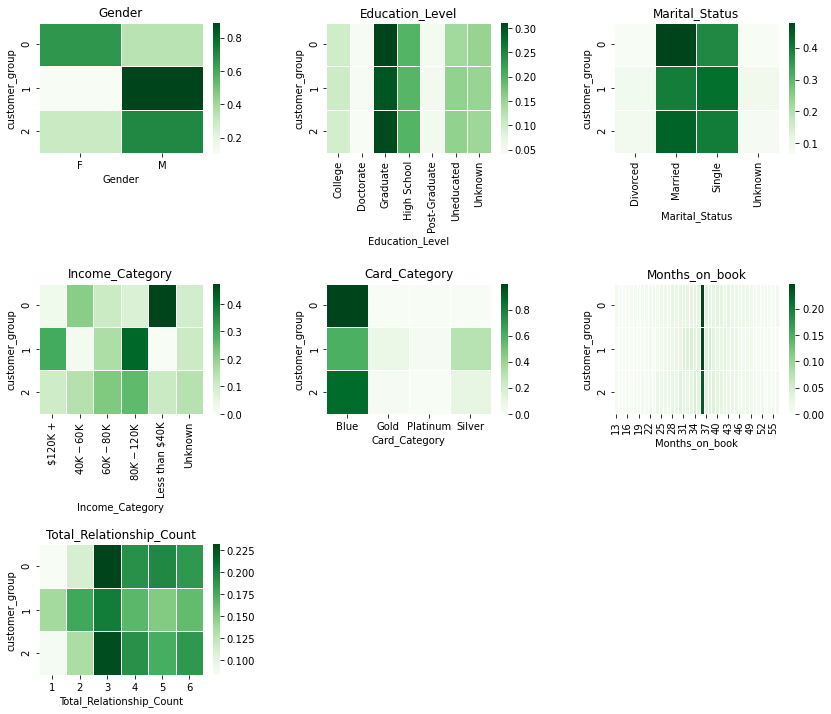

In [30]:
cat_var = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 
          'Card_Category', 'Months_on_book', 'Total_Relationship_Count']



fig = plt.figure(figsize=(14, 12))
fig.subplots_adjust(hspace=1.0, wspace=0.4)
for i,var in enumerate(cat_var):
    ax = fig.add_subplot(3, 3, i+1)
    ax = sns.heatmap(pd.crosstab(segment_frame['customer_group'], 
                                 segment_frame[var], normalize='index'), 
                     cmap='Greens', linewidths=0.5)
    ax.set_title(var)
    

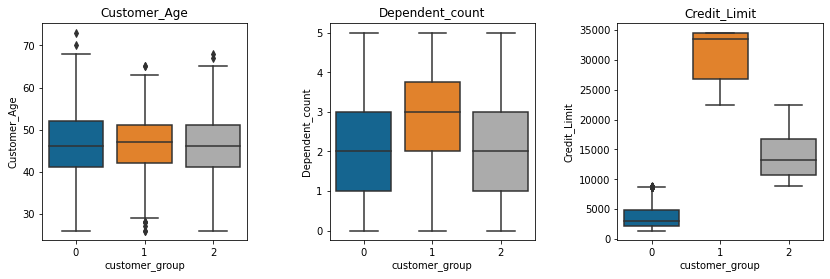

In [31]:
num_var = ['Customer_Age', 'Dependent_count', 'Credit_Limit']

fig = plt.figure(figsize=(14, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i,var in enumerate(num_var):
    ax = fig.add_subplot(1, 3, i+1)
    ax = sns.boxplot(data=segment_frame, x='customer_group', y=var)
    ax.set_title(var)
    

In [32]:
# Create customer profile table
customer_profile = pd.merge(df[['CLIENTNUM'] + behavior_features], 
                            segment_frame[['CLIENTNUM', 'customer_group']], 
                            on='CLIENTNUM')
customer_profile = customer_profile.drop(columns=['CLIENTNUM'])
customer_profile.head()

,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,customer_group
0,1,3,777,11914.0,1.335,1144,42,1.625,0.061,2
1,1,2,864,7392.0,1.541,1291,33,3.714,0.105,0
2,1,0,0,3418.0,2.594,1887,20,2.333,0.000,0
3,4,1,2517,796.0,1.405,1171,20,2.333,0.760,0
4,1,0,0,4716.0,2.175,816,28,2.500,0.000,0


In [33]:
behavior_features

['Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [34]:
# visualize behavior using radar plot for each group
fig = px.parallel_coordinates(customer_profile, color='customer_group', 
                             dimensions=['Avg_Open_To_Buy', 'Avg_Utilization_Ratio', 
                                         'Total_Trans_Amt', 'Total_Trans_Ct'
                                        ])
fig.show()




In [35]:

# radar
tmp = customer_profile.groupby('customer_group').mean()
tmp = tmp.apply(lambda x: x/x.max(), axis=0)

# tmp
var = tmp.columns.tolist()[1:]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(r = tmp.iloc[0, 1:].values.tolist(), 
                             theta = var, 
                             fill ='toself', 
                             name = 'Group 0'))
fig.add_trace(go.Scatterpolar(r = tmp.iloc[1, 1:].values.tolist(), 
                             theta = var, 
                             fill ='toself', 
                             name = 'Group 1'))
fig.add_trace(go.Scatterpolar(r = tmp.iloc[2, 1:].values.tolist(), 
                             theta = var, 
                             fill ='toself', 
                             name = 'Group 2'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True)), showlegend=True)
fig.show()

# data = pd.DataFrame(dict(r = tmp.iloc[0, 1:].values.tolist(), 
#                         theta = var))
# fig = px.line_polar(data, r='r', theta='theta', 
#                     line_close=True)
# fig.show()


## Feature Engineering
* Binning : Customer_Age, Months_on_book, Credit_Limit, Total_Revolving_Bal, <br>Avg_Open_To_Buy, Total_Amt_Chng_Q4_Q1, Total_Trans_Amt, Total_Trans_Ct, <br>Total_Ct_Chng_Q4_Q1, Avg_Utilization_Ratio
* Weight of Evidence


In [36]:
df = pd.read_csv('/kaggle/input/credit-card-customers/BankChurners.csv')
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [37]:
# drop columns
df = df.drop(columns = ['CLIENTNUM', 
              'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 
             'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

### Binning

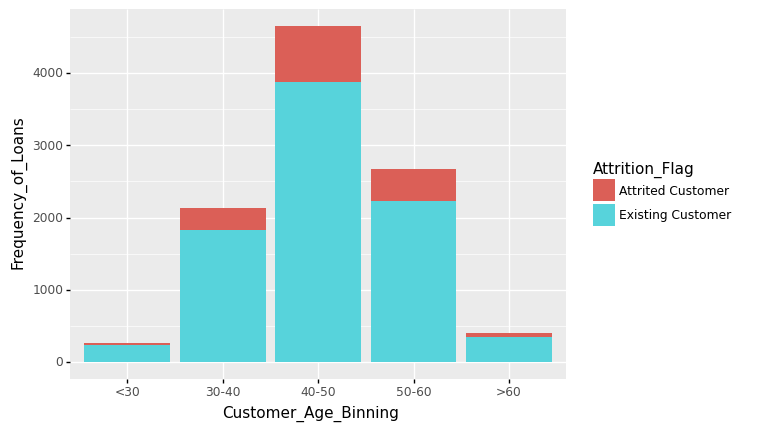

<ggplot: (8791551055217)>

In [38]:
# Customer_Age : <20, 20-30, 30-40, 40-50, 50-60, >60
converter = lambda x: '<30' if (x <= 30) else \
                        ('30-40' if (x > 30 and x <= 40) else \
                        ('40-50' if (x > 40 and x <= 50) else \
                        ('50-60' if (x > 50 and x <= 60) else \
                        '>60')))


tmp = df['Customer_Age'].apply(converter)
df['Customer_Age_Binning'] = tmp

tmp2 = df.groupby('Customer_Age_Binning')['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'Attrition_Flag':'Frequency_of_Loans'})
tmp2 = tmp2.reset_index()

tmp2['Customer_Age_Binning'] = pd.Categorical(tmp2['Customer_Age_Binning'], 
                                              categories=['<30','30-40','40-50','50-60','>60'], 
                                              ordered=True)
fig_age_bin = ggplot(tmp2) +\
                geom_col(aes(x='Customer_Age_Binning', y='Frequency_of_Loans', fill='Attrition_Flag'))
fig_age_bin

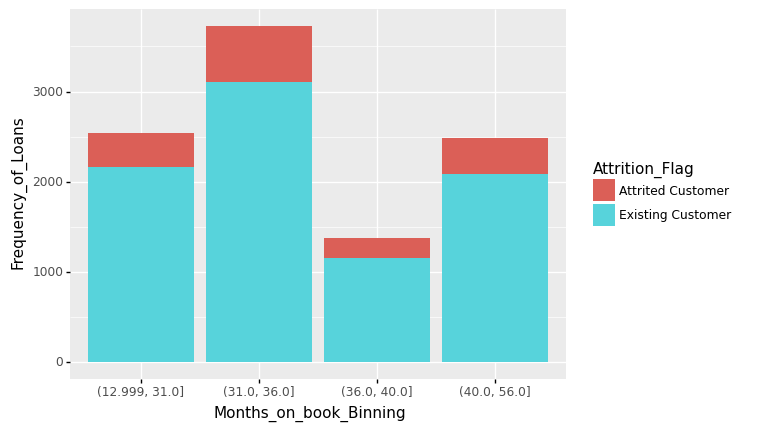

<ggplot: (8791551531821)>

In [39]:
# Months_on_book
var = 'Months_on_book'
var_binning = var + '_Binning'
tmp = pd.qcut(df[var], q=4)
df[var_binning] = tmp

tmp2 = df.groupby(var_binning)['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'Attrition_Flag':'Frequency_of_Loans'})
tmp2 = tmp2.reset_index()

fig_mob_bin = ggplot(tmp2) +\
                        geom_col(aes(x=var_binning, y='Frequency_of_Loans', 
                                    fill='Attrition_Flag'))
fig_mob_bin


In [40]:
# ggsave(fig_mob_bin, './fig4_mob_binning.png')

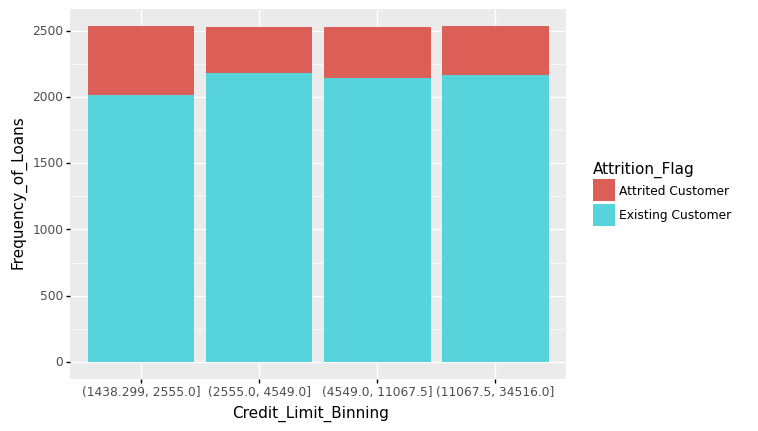

<ggplot: (8791551125057)>

In [41]:
# Credit_Limit
var = 'Credit_Limit'
var_binning = var + '_Binning'
tmp = pd.qcut(df[var], q=4)
df[var_binning] = tmp

tmp2 = df.groupby(var_binning)['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'Attrition_Flag':'Frequency_of_Loans'})
tmp2 = tmp2.reset_index()

fig_creditlim_bin = ggplot(tmp2) +\
                        geom_col(aes(x=var_binning, y='Frequency_of_Loans', 
                                    fill='Attrition_Flag'))
fig_creditlim_bin


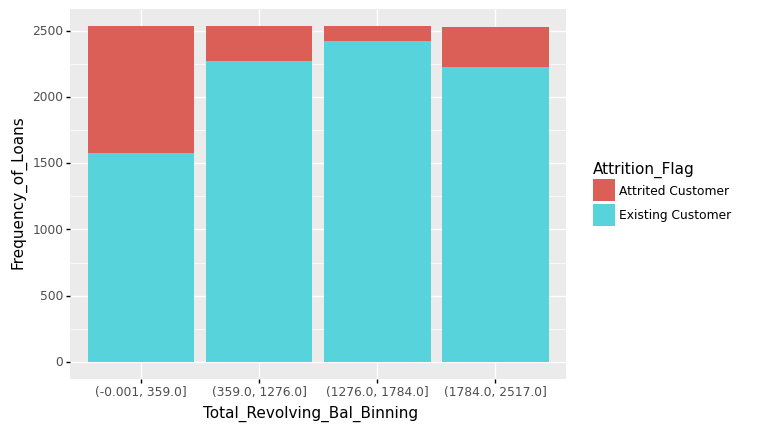

<ggplot: (8791551532585)>

In [42]:
# Total_Revolving_Bal
var = 'Total_Revolving_Bal'
var_binning = var + '_Binning'
tmp = pd.qcut(df[var], q=4)
df[var_binning] = tmp

tmp2 = df.groupby(var_binning)['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'Attrition_Flag':'Frequency_of_Loans'})
tmp2 = tmp2.reset_index()

fig_revolve_bin = ggplot(tmp2) +\
                        geom_col(aes(x=var_binning, y='Frequency_of_Loans', 
                                    fill='Attrition_Flag'))
fig_revolve_bin


In [43]:
# ggsave(fig_revolve_bin, './fig6_revolve_binning.png')

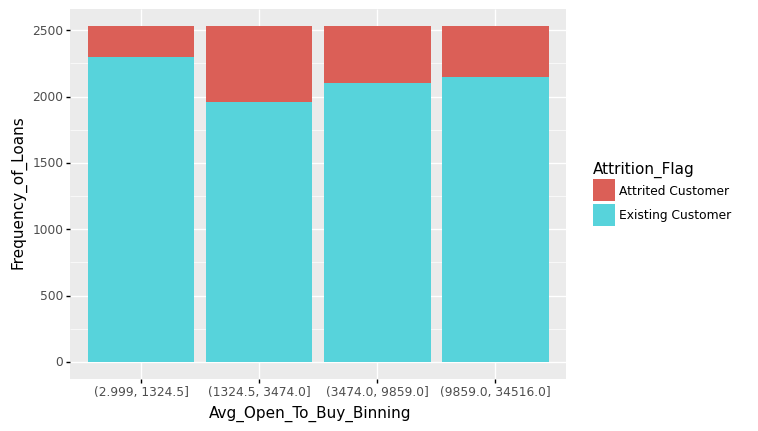

<ggplot: (8791569836257)>

In [44]:
# Avg_Open_To_Buy
var = 'Avg_Open_To_Buy'
var_binning = var + '_Binning'
tmp = pd.qcut(df[var], q=4)
df[var_binning] = tmp

tmp2 = df.groupby(var_binning)['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'Attrition_Flag':'Frequency_of_Loans'})
tmp2 = tmp2.reset_index()

fig_opentobuy_bin = ggplot(tmp2) +\
                        geom_col(aes(x=var_binning, y='Frequency_of_Loans', 
                                    fill='Attrition_Flag'))
fig_opentobuy_bin


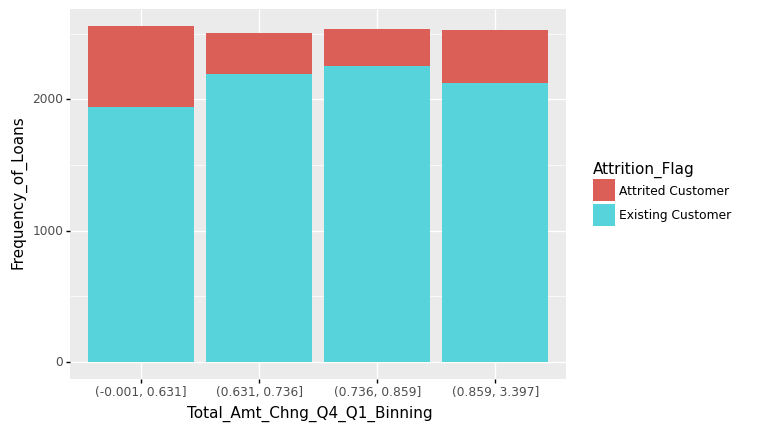

<ggplot: (8791569883477)>

In [45]:
# Total_Amt_Chng_Q4_Q1, 

var = 'Total_Amt_Chng_Q4_Q1'
var_binning = var + '_Binning'
tmp = pd.qcut(df[var], q=4)
df[var_binning] = tmp

tmp2 = df.groupby(var_binning)['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'Attrition_Flag':'Frequency_of_Loans'})
tmp2 = tmp2.reset_index()

fig_amtq4q1_bin = ggplot(tmp2) +\
                        geom_col(aes(x=var_binning, y='Frequency_of_Loans', 
                                    fill='Attrition_Flag'))
fig_amtq4q1_bin

In [46]:
# ggsave(fig_amtq4q1_bin, './fig6_amtq4q1_binning.png')


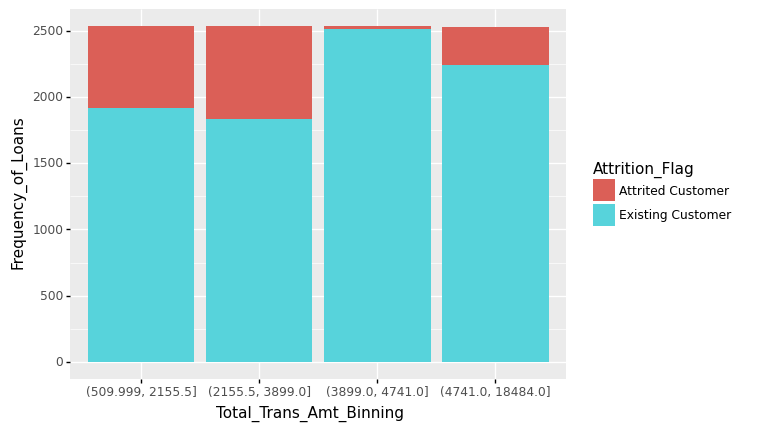

<ggplot: (8791569877509)>

In [47]:
# Total_Trans_Amt 

var = 'Total_Trans_Amt'
var_binning = var + '_Binning'
tmp = pd.qcut(df[var], q=4)
df[var_binning] = tmp

tmp2 = df.groupby(var_binning)['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'Attrition_Flag':'Frequency_of_Loans'})
tmp2 = tmp2.reset_index()

fig_transamt_bin = ggplot(tmp2) +\
                        geom_col(aes(x=var_binning, y='Frequency_of_Loans', 
                                    fill='Attrition_Flag'))
fig_transamt_bin

In [48]:
# ggsave(fig_transamt_bin, './fig9_transamt_binning.png')


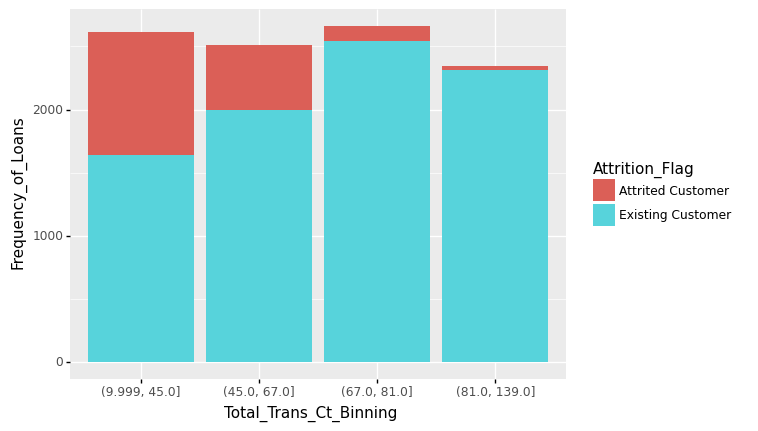

<ggplot: (8791569887469)>

In [49]:
# Total_Trans_Ct

var = 'Total_Trans_Ct'
var_binning = var + '_Binning'
tmp = pd.qcut(df[var], q=4)
df[var_binning] = tmp

tmp2 = df.groupby(var_binning)['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'Attrition_Flag':'Frequency_of_Loans'})
tmp2 = tmp2.reset_index()

fig_transct_bin = ggplot(tmp2) +\
                        geom_col(aes(x=var_binning, y='Frequency_of_Loans', 
                                    fill='Attrition_Flag'))
fig_transct_bin

In [50]:
# ggsave(fig_transct_bin, './fig10_transct_binning.png')

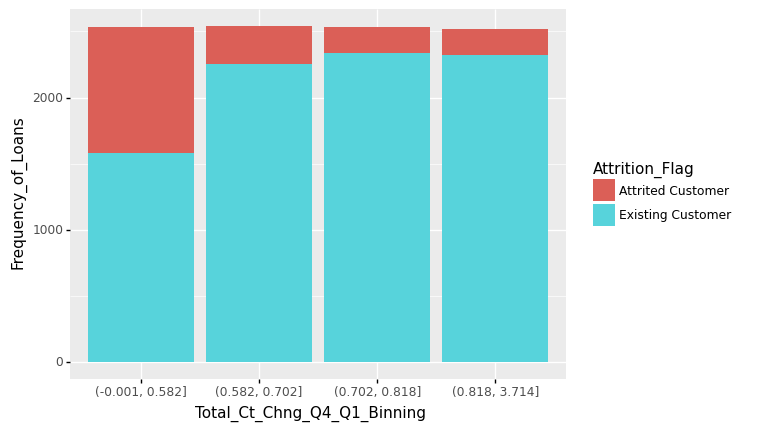

<ggplot: (8791569776709)>

In [51]:
# Total_Ct_Chng_Q4_Q1,
var = 'Total_Ct_Chng_Q4_Q1'
var_binning = var + '_Binning'
tmp = pd.qcut(df[var], q=4)
df[var_binning] = tmp

tmp2 = df.groupby(var_binning)['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'Attrition_Flag':'Frequency_of_Loans'})
tmp2 = tmp2.reset_index()

fig_ctq4q1_bin = ggplot(tmp2) +\
                        geom_col(aes(x=var_binning, y='Frequency_of_Loans', 
                                    fill='Attrition_Flag'))
fig_ctq4q1_bin

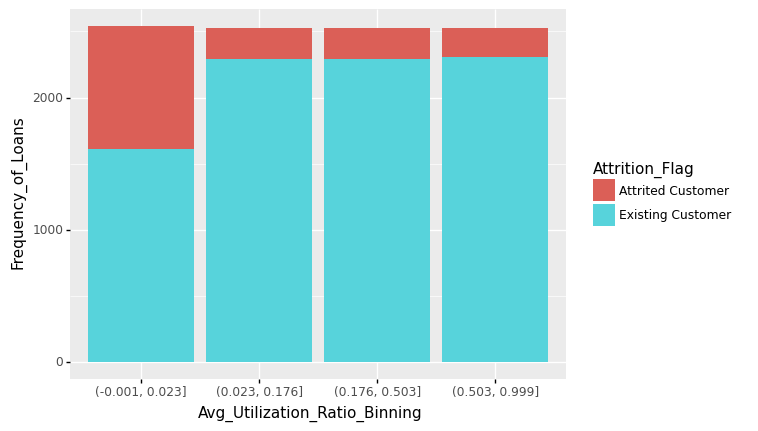

<ggplot: (8791569902445)>

In [52]:
# Avg_Utilization_Ratio
var = 'Avg_Utilization_Ratio'
var_binning = var + '_Binning'
tmp = pd.qcut(df[var], q=4)
df[var_binning] = tmp

tmp2 = df.groupby(var_binning)['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'Attrition_Flag':'Frequency_of_Loans'})
tmp2 = tmp2.reset_index()

fig_utilize_bin = ggplot(tmp2) +\
                        geom_col(aes(x=var_binning, y='Frequency_of_Loans', 
                                    fill='Attrition_Flag'))
fig_utilize_bin

### WOE

In [53]:
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Customer_Age_Binning,Months_on_book_Binning,Credit_Limit_Binning,Total_Revolving_Bal_Binning,Avg_Open_To_Buy_Binning,Total_Amt_Chng_Q4_Q1_Binning,Total_Trans_Amt_Binning,Total_Trans_Ct_Binning,Total_Ct_Chng_Q4_Q1_Binning,Avg_Utilization_Ratio_Binning
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,40-50,"(36.0, 40.0]","(11067.5, 34516.0]","(359.0, 1276.0]","(9859.0, 34516.0]","(0.859, 3.397]","(509.999, 2155.5]","(9.999, 45.0]","(0.818, 3.714]","(0.023, 0.176]"
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,...,40-50,"(40.0, 56.0]","(4549.0, 11067.5]","(359.0, 1276.0]","(3474.0, 9859.0]","(0.859, 3.397]","(509.999, 2155.5]","(9.999, 45.0]","(0.818, 3.714]","(0.023, 0.176]"
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,50-60,"(31.0, 36.0]","(2555.0, 4549.0]","(-0.001, 359.0]","(1324.5, 3474.0]","(0.859, 3.397]","(509.999, 2155.5]","(9.999, 45.0]","(0.818, 3.714]","(-0.001, 0.023]"
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,30-40,"(31.0, 36.0]","(2555.0, 4549.0]","(1784.0, 2517.0]","(2.999, 1324.5]","(0.859, 3.397]","(509.999, 2155.5]","(9.999, 45.0]","(0.818, 3.714]","(0.503, 0.999]"
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,30-40,"(12.999, 31.0]","(4549.0, 11067.5]","(-0.001, 359.0]","(3474.0, 9859.0]","(0.859, 3.397]","(509.999, 2155.5]","(9.999, 45.0]","(0.818, 3.714]","(-0.001, 0.023]"


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Attrition_Flag                 10127 non-null  object  
 1   Customer_Age                   10127 non-null  int64   
 2   Gender                         10127 non-null  object  
 3   Dependent_count                10127 non-null  int64   
 4   Education_Level                10127 non-null  object  
 5   Marital_Status                 10127 non-null  object  
 6   Income_Category                10127 non-null  object  
 7   Card_Category                  10127 non-null  object  
 8   Months_on_book                 10127 non-null  int64   
 9   Total_Relationship_Count       10127 non-null  int64   
 10  Months_Inactive_12_mon         10127 non-null  int64   
 11  Contacts_Count_12_mon          10127 non-null  int64   
 12  Credit_Limit                   1

In [55]:
df['Attrition_Flag'].value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

In [56]:
df['Card_Category'].value_counts()

Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64

In [57]:
df[df['Avg_Utilization_Ratio'] == 0]['Attrition_Flag'].value_counts()

Existing Customer    1577
Attrited Customer     893
Name: Attrition_Flag, dtype: int64

In [58]:
selected_feature = ['Attrition_Flag', 
                   'Gender', 'Customer_Age_Binning', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 
                   'Months_on_book_Binning', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 
                   'Credit_Limit_Binning', 'Total_Revolving_Bal_Binning', 'Avg_Open_To_Buy_Binning', 'Total_Amt_Chng_Q4_Q1_Binning', 
                   'Total_Trans_Amt_Binning', 'Total_Trans_Ct_Binning', 'Total_Ct_Chng_Q4_Q1_Binning', 'Avg_Utilization_Ratio_Binning']

df = df[selected_feature]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Attrition_Flag                 10127 non-null  object  
 1   Gender                         10127 non-null  object  
 2   Customer_Age_Binning           10127 non-null  object  
 3   Dependent_count                10127 non-null  int64   
 4   Education_Level                10127 non-null  object  
 5   Marital_Status                 10127 non-null  object  
 6   Income_Category                10127 non-null  object  
 7   Months_on_book_Binning         10127 non-null  category
 8   Total_Relationship_Count       10127 non-null  int64   
 9   Months_Inactive_12_mon         10127 non-null  int64   
 10  Contacts_Count_12_mon          10127 non-null  int64   
 11  Credit_Limit_Binning           10127 non-null  category
 12  Total_Revolving_Bal_Binning    1

In [59]:
iv_list = []

# loop
for var in selected_feature[1:]:
    new_var = var + '_woe'
    # create woe table
    tmp = df.groupby(var)['Attrition_Flag'].value_counts()
    tmp = pd.DataFrame(tmp)
    tmp = tmp.rename(columns={'Attrition_Flag':'Frequency_of_Loans'})
    tmp = tmp.reset_index()
    woe_table = tmp.pivot(index=var, columns='Attrition_Flag', values='Frequency_of_Loans')

    # calculate WOE&IV
    num_attrited = woe_table['Attrited Customer'].sum()
    num_existing = woe_table['Existing Customer'].sum()

    woe_table['DB'] = woe_table['Attrited Customer']/num_attrited
    woe_table['DG'] = woe_table['Existing Customer']/num_existing
    woe_table['perc_diff'] = woe_table['DG']-woe_table['DB']
    woe_table['woe'] = np.log(woe_table['DG']/woe_table['DB'])

    # store IV value
    iv_data = {'var':var, 
               'iv':(woe_table['perc_diff']*woe_table['woe']).sum()}
    iv_list.append(iv_data)

    # transform categorical into woe
    df[new_var] = pd.merge(df, woe_table, how='left', left_on=var, 
                                right_index=True)['woe']



In [60]:
df.head()

,Attrition_Flag,Gender,Customer_Age_Binning,Dependent_count,Education_Level,Marital_Status,Income_Category,Months_on_book_Binning,Total_Relationship_Count,Months_Inactive_12_mon,...,Months_Inactive_12_mon_woe,Contacts_Count_12_mon_woe,Credit_Limit_Binning_woe,Total_Revolving_Bal_Binning_woe,Avg_Open_To_Buy_Binning_woe,Total_Amt_Chng_Q4_Q1_Binning_woe,Total_Trans_Amt_Binning_woe,Total_Trans_Ct_Binning_woe,Total_Ct_Chng_Q4_Q1_Binning_woe,Avg_Utilization_Ratio_Binning_woe
0,Existing Customer,M,40-50,3,High School,Married,$60K - $80K,"(36.0, 40.0]",5,1,...,1.406786,-0.276254,0.115126,0.510127,0.065255,0.019708,-0.522866,-1.124281,0.840652,0.625138
1,Existing Customer,F,40-50,5,Graduate,Single,Less than $40K,"(40.0, 56.0]",6,1,...,1.406786,0.293645,0.057742,0.510127,-0.066945,0.019708,-0.522866,-1.124281,0.840652,0.625138
2,Existing Customer,M,50-60,3,Graduate,Married,$80K - $120K,"(31.0, 36.0]",4,1,...,1.406786,2.372023,0.163078,-1.151760,-0.430779,0.019708,-0.522866,-1.124281,0.840652,-1.103903
3,Existing Customer,F,30-40,4,High School,Unknown,Less than $40K,"(31.0, 36.0]",3,4,...,-0.800551,0.902319,0.163078,0.347972,0.621764,0.019708,-0.522866,-1.124281,0.840652,0.672539
4,Existing Customer,M,30-40,3,Uneducated,Married,$60K - $80K,"(12.999, 31.0]",5,1,...,1.406786,2.372023,0.057742,-1.151760,-0.066945,0.019708,-0.522866,-1.124281,0.840652,-1.103903


## Feature Selection

In [61]:
# IV
iv_table = pd.DataFrame(iv_list)
iv_table = iv_table.sort_values('iv', ascending=True).reset_index(drop=True)
iv_table['var'] = pd.Categorical(iv_table['var'], categories=iv_table['var'].unique().tolist(), 
                                 ordered=True)
iv_table

,var,iv
0,Months_on_book_Binning,0.003773
1,Marital_Status,0.004440
2,Dependent_count,0.006905
3,Customer_Age_Binning,0.007913
4,Education_Level,0.008515
5,Income_Category,0.009700
6,Gender,0.010365
7,Credit_Limit_Binning,0.033710
8,Total_Amt_Chng_Q4_Q1_Binning,0.130210
9,Avg_Open_To_Buy_Binning,0.133325


In [62]:
iv_table = iv_table.rename(columns={'iv':'information value'})
iv_table.head()

,var,information value
0,Months_on_book_Binning,0.003773
1,Marital_Status,0.004440
2,Dependent_count,0.006905
3,Customer_Age_Binning,0.007913
4,Education_Level,0.008515


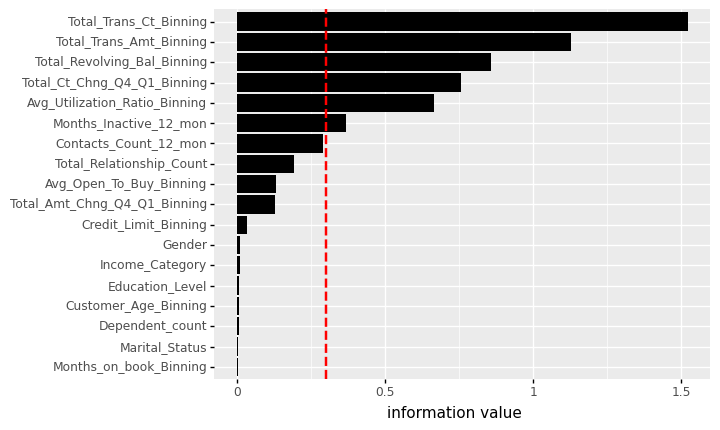

<ggplot: (8791551265513)>

In [63]:
ggplot(iv_table) +\
    geom_col(aes(x='var', y='information value'), fill='black') +\
    geom_hline(yintercept=0.3, linetype='dashed', color='red', size=1.0) +\
    theme(axis_title_y = element_blank()) +\
    coord_flip()


## Churner Profile

In [64]:
#  
selected_features = iv_table[iv_table['information value'] >= 0.3]['var'].unique().tolist()[::-1]
selected_features

['Total_Trans_Ct_Binning',
 'Total_Trans_Amt_Binning',
 'Total_Revolving_Bal_Binning',
 'Total_Ct_Chng_Q4_Q1_Binning',
 'Avg_Utilization_Ratio_Binning',
 'Months_Inactive_12_mon']

In [65]:
org_df = pd.read_csv('/kaggle/input/credit-card-customers/BankChurners.csv')
org_df.head()

var = ['Attrition_Flag', 
       'Total_Trans_Ct',
       'Total_Trans_Amt',
       'Total_Revolving_Bal',
       'Total_Ct_Chng_Q4_Q1',
       'Avg_Utilization_Ratio',
       'Months_Inactive_12_mon']

org_df[var]

,Attrition_Flag,Total_Trans_Ct,Total_Trans_Amt,Total_Revolving_Bal,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Months_Inactive_12_mon
0,Existing Customer,42,1144,777,1.625,0.061,1
1,Existing Customer,33,1291,864,3.714,0.105,1
2,Existing Customer,20,1887,0,2.333,0.000,1
3,Existing Customer,20,1171,2517,2.333,0.760,4
4,Existing Customer,28,816,0,2.500,0.000,1
...,...,...,...,...,...,...,...
10122,Existing Customer,117,15476,1851,0.857,0.462,2
10123,Attrited Customer,69,8764,2186,0.683,0.511,2
10124,Attrited Customer,60,10291,0,0.818,0.000,3
10125,Attrited Customer,62,8395,0,0.722,0.000,3


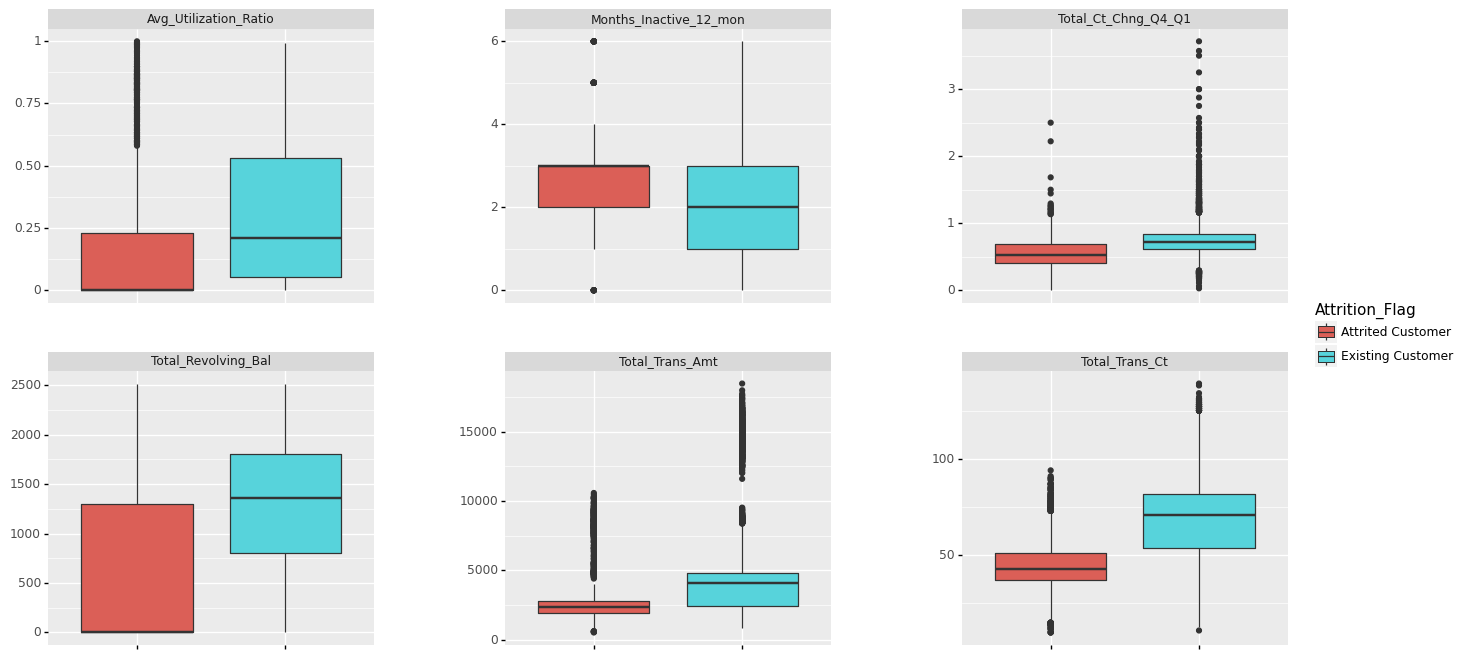

<ggplot: (8791569233885)>

In [66]:
tmp = pd.melt(org_df[var], id_vars='Attrition_Flag')

ggplot(tmp, aes(x='Attrition_Flag', y='value', fill='Attrition_Flag')) +\
    geom_boxplot() +\
    facet_wrap('variable', scales='free_y') +\
    theme(subplots_adjust={'wspace':0.40, 'hspace':0.25}, 
          axis_text_x=element_blank(), 
         axis_title_x=element_blank(), 
         axis_title_y=element_blank(), 
         figure_size=(16,8))
    


In [67]:
org_df.groupby('Attrition_Flag')[var].agg([np.mean, np.std])

Total_Trans_Ct            Total_Trans_Amt               \
                            mean        std            mean          std   
Attrition_Flag                                                             
Attrited Customer      44.933620  14.568429     3095.025814  2308.227629   
Existing Customer      68.672588  22.919011     4654.655882  3512.772635   

                  Total_Revolving_Bal             Total_Ct_Chng_Q4_Q1  \
                                 mean         std                mean   
Attrition_Flag                                                          
Attrited Customer          672.822987  921.385582            0.554386   
Existing Customer         1256.604118  757.745354            0.742434   

                            Avg_Utilization_Ratio            \
                        std                  mean       std   
Attrition_Flag                                                
Attrited Customer  0.226854              0.162475  0.264458   
Existing Customer  0.228054              0.296412  0.272568   

                  Months_Inactive_12_mon            
                                    mean       std  
Attrition_Flag                                      
Attrited Customer               2.693301  0.899623  
Existing Customer               2.273765  1.016741

## Churn Prediction Model
* Dealing with imbalance data using SMOTE
* Logistic Regression
* Diagnosis
* Evaluation


In [68]:
# df
selected_features_woe = [x + '_woe' for x in selected_features]
df = df[['Attrition_Flag'] + selected_features_woe]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Attrition_Flag                     10127 non-null  object 
 1   Total_Trans_Ct_Binning_woe         10127 non-null  float64
 2   Total_Trans_Amt_Binning_woe        10127 non-null  float64
 3   Total_Revolving_Bal_Binning_woe    10127 non-null  float64
 4   Total_Ct_Chng_Q4_Q1_Binning_woe    10127 non-null  float64
 5   Avg_Utilization_Ratio_Binning_woe  10127 non-null  float64
 6   Months_Inactive_12_mon_woe         10127 non-null  float64
dtypes: float64(6), object(1)
memory usage: 553.9+ KB


In [69]:
df['Attrition_Flag'].value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

In [70]:
# split train/test 80:20
X = df[selected_features_woe]
y = df['Attrition_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.20, 
                                                    random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(8101, 6) (8101,)
(2026, 6) (2026,)


In [71]:
print('train : {}\ntest : {}'.format(Counter(y_train), Counter(y_test)))

train : Counter({'Existing Customer': 6799, 'Attrited Customer': 1302})
test : Counter({'Existing Customer': 1701, 'Attrited Customer': 325})


### SMOTE on training data
* use typical k (k=5)

In [72]:
# oversampling
smote =  imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                   k_neighbors=5, 
                                   random_state=42)

X_res, y_res = smote.fit_resample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))


Resampled dataset shape Counter({'Attrited Customer': 6799, 'Existing Customer': 6799})


In [73]:
df_train = pd.concat([X_res, pd.DataFrame({'Attrition_Flag':y_res})], axis=1)
df_train.head()


,Total_Trans_Ct_Binning_woe,Total_Trans_Amt_Binning_woe,Total_Revolving_Bal_Binning_woe,Total_Ct_Chng_Q4_Q1_Binning_woe,Avg_Utilization_Ratio_Binning_woe,Months_Inactive_12_mon_woe,Attrition_Flag
0,-1.124281,-0.522866,-1.151760,-1.146915,-1.103903,0.051240,Attrited Customer
1,2.836172,0.390575,0.347972,0.840652,0.615792,0.051240,Existing Customer
2,1.408648,-0.685314,1.439778,-1.146915,0.615792,0.051240,Existing Customer
3,-1.124281,-0.522866,1.439778,0.411585,0.615792,-0.356911,Existing Customer
4,1.408648,3.084464,0.510127,0.411585,0.625138,0.051240,Existing Customer


In [74]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13598 entries, 0 to 13597
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Total_Trans_Ct_Binning_woe         13598 non-null  float64
 1   Total_Trans_Amt_Binning_woe        13598 non-null  float64
 2   Total_Revolving_Bal_Binning_woe    13598 non-null  float64
 3   Total_Ct_Chng_Q4_Q1_Binning_woe    13598 non-null  float64
 4   Avg_Utilization_Ratio_Binning_woe  13598 non-null  float64
 5   Months_Inactive_12_mon_woe         13598 non-null  float64
 6   Attrition_Flag                     13598 non-null  object 
dtypes: float64(6), object(1)
memory usage: 743.8+ KB


### Logistic Regression
* GLM 
* Diagnosis : Goodness of Fit, Overdispersion, Influence
* Evaluation

ref.<br>
https://www.statsmodels.org/stable/examples/notebooks/generated/glm_formula.html <br>
https://www.statsmodels.org/stable/examples/notebooks/generated/influence_glm_logit.html <br>


In [75]:
df_train.columns

Index(['Total_Trans_Ct_Binning_woe', 'Total_Trans_Amt_Binning_woe',
       'Total_Revolving_Bal_Binning_woe', 'Total_Ct_Chng_Q4_Q1_Binning_woe',
       'Avg_Utilization_Ratio_Binning_woe', 'Months_Inactive_12_mon_woe',
       'Attrition_Flag'],
      dtype='object')

In [76]:
formula = 'Attrition_Flag ~ 0 + Total_Trans_Ct_Binning_woe +\
                            Total_Trans_Amt_Binning_woe +\
                            Total_Revolving_Bal_Binning_woe +\
                            Total_Ct_Chng_Q4_Q1_Binning_woe +\
                            Avg_Utilization_Ratio_Binning_woe +\
                            Months_Inactive_12_mon_woe'


model1 = smf.glm(data = df_train, formula=formula, family=sm.families.Binomial()).fit()
print(model1.summary())


                                             Generalized Linear Model Regression Results                                              
Dep. Variable:     ['Attrition_Flag[Attrited Customer]', 'Attrition_Flag[Existing Customer]']   No. Observations:                13598
Model:                                                                                    GLM   Df Residuals:                    13592
Model Family:                                                                        Binomial   Df Model:                            5
Link Function:                                                                          logit   Scale:                          1.0000
Method:                                                                                  IRLS   Log-Likelihood:                -5345.8
Date:                                                                        Tue, 06 Jul 2021   Deviance:                       10692.
Time:                                                  

Based on the results of Wald's test, we omit the variable <br>Avg_Utilization_Ratio_Binning_woe because p-value > 0.05.

In [77]:
# prediction 
model1.mu

array([0.94318834, 0.04726387, 0.18193932, ..., 0.78378998, 0.25708075,
       0.9619582 ])

#### Diagnosis

In [78]:
# Goodness of Fit : I use Hosmer-Lemeshow test instead Deviance due to our target variable was binary response 
## https://en.wikipedia.org/wiki/Hosmer%E2%80%93Lemeshow_test

# H-L component
obs = pd.get_dummies(df_train['Attrition_Flag'])
prob =  pd.DataFrame({'prob':model1.mu})
q_prob = pd.DataFrame({'q_prob':pd.qcut(prob['prob'], q=10)})
hl_frame = pd.concat([obs, prob, q_prob], axis=1)

# H-L statframe
hl_pivotframe = hl_frame.groupby('q_prob').agg({'Attrited Customer':'sum', 
                                                'Existing Customer':'sum', 
                                                'prob':'mean'})

# calculate H-L
hl_pivotframe['obs_all'] = hl_pivotframe.iloc[:, 0] + hl_pivotframe.iloc[:, 1]
hl_pivotframe['expect_1'] = hl_pivotframe['prob'] * hl_pivotframe['obs_all']
hl_pivotframe['expect_0'] = hl_pivotframe['obs_all'] - hl_pivotframe['expect_1']

hl_pivotframe['HL'] = ((hl_pivotframe['Attrited Customer'] - hl_pivotframe['expect_1'])**2/hl_pivotframe['expect_1']) +\
                        ((hl_pivotframe['Existing Customer'] - hl_pivotframe['expect_0'])**2/hl_pivotframe['expect_0'])
hl_pivotframe



,Attrited Customer,Existing Customer,prob,obs_all,expect_1,expect_0,HL
q_prob,,,,,,,
"(2.0000000000000052e-05, 0.0235]",10.0,1352.0,0.012249,1362.0,16.683732,1345.316268,2.710801
"(0.0235, 0.0701]",92.0,1270.0,0.045584,1362.0,62.084735,1299.915265,15.102990
"(0.0701, 0.183]",191.0,1167.0,0.118411,1358.0,160.801961,1197.198039,6.432798
"(0.183, 0.364]",279.0,1078.0,0.255560,1357.0,346.795558,1010.204442,17.803260
"(0.364, 0.52]",700.0,669.0,0.448163,1369.0,613.534922,755.465078,22.081636
"(0.52, 0.667]",726.0,625.0,0.594462,1351.0,803.118709,547.881291,18.260330
"(0.667, 0.804]",1072.0,300.0,0.752329,1372.0,1032.194939,339.805061,6.197823
"(0.804, 0.886]",1131.0,216.0,0.842459,1347.0,1134.792867,212.207133,0.080469
"(0.886, 0.947]",1488.0,99.0,0.929845,1587.0,1475.663554,111.336446,1.470051


In [79]:
# calculate H-L stat and p-value
hl_stat = hl_pivotframe['HL'].sum()
p_value = 1 - stats.chi2.cdf(hl_stat, 8)
print('H-L = {}\np-value = {}'.format(hl_stat, p_value))


H-L = 97.49791803295909
p-value = 0.0


From the H-L test, it was found that the overall model had Goodness of Fit.

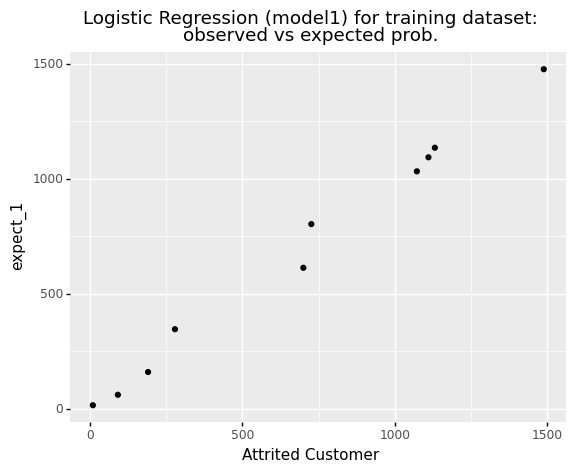

<ggplot: (8791520857321)>

In [80]:
ggplot(hl_pivotframe) +\
    geom_point(aes(x='Attrited Customer', y='expect_1')) +\
    labs(title='Logistic Regression (model1) for training dataset:\nobserved vs expected prob.')
    

In [81]:
# Checking Overdispersion 
print('estimated phi_hat : {}'.format(model1.pearson_chi2/model1.df_resid))


estimated phi_hat : 0.972160377191735


Overdispersion not found

In [82]:
# Filter Influencer
infl = model1.get_influence(observed=False)
summ_df = infl.summary_frame()
threshold = 4/(df_train.shape[0] - len(model1.params))
infl_index = summ_df['cooks_d'] > threshold


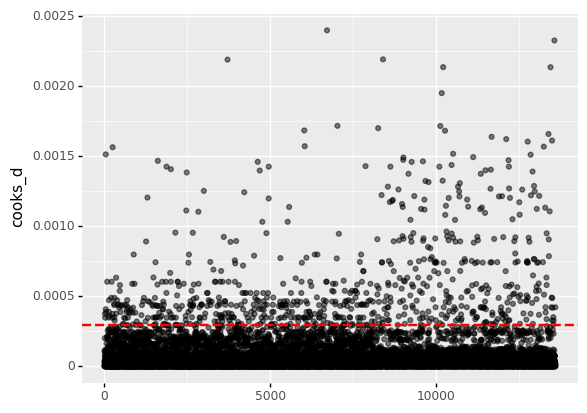

<ggplot: (8791520831017)>

In [83]:
ggplot(summ_df) +\
    geom_point(aes(x=summ_df.index, y=summ_df['cooks_d']), alpha=0.5) +\
    geom_hline(yintercept=threshold, linetype='dashed', color='red', size=1.0)

note:
from all diagnosis I will
1. remove Avg_Utilization_Ratio_Binning_woe from the model
2. Filter influencer
then fitting the new model

In [84]:
# remove Avg_Utilization_Ratio_Binning_woe
df_train = df_train.drop(columns='Avg_Utilization_Ratio_Binning_woe')

In [85]:
df_train[~infl_index]['Attrition_Flag'].value_counts()

Existing Customer    6489
Attrited Customer    6394
Name: Attrition_Flag, dtype: int64

In [86]:
# Filter influencer
newdf_train = df_train[~infl_index]
newdf_train.head()

,Total_Trans_Ct_Binning_woe,Total_Trans_Amt_Binning_woe,Total_Revolving_Bal_Binning_woe,Total_Ct_Chng_Q4_Q1_Binning_woe,Months_Inactive_12_mon_woe,Attrition_Flag
0,-1.124281,-0.522866,-1.151760,-1.146915,0.051240,Attrited Customer
1,2.836172,0.390575,0.347972,0.840652,0.051240,Existing Customer
2,1.408648,-0.685314,1.439778,-1.146915,0.051240,Existing Customer
3,-1.124281,-0.522866,1.439778,0.411585,-0.356911,Existing Customer
4,1.408648,3.084464,0.510127,0.411585,0.051240,Existing Customer


In [87]:
newdf_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12883 entries, 0 to 13597
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Total_Trans_Ct_Binning_woe       12883 non-null  float64
 1   Total_Trans_Amt_Binning_woe      12883 non-null  float64
 2   Total_Revolving_Bal_Binning_woe  12883 non-null  float64
 3   Total_Ct_Chng_Q4_Q1_Binning_woe  12883 non-null  float64
 4   Months_Inactive_12_mon_woe       12883 non-null  float64
 5   Attrition_Flag                   12883 non-null  object 
dtypes: float64(5), object(1)
memory usage: 704.5+ KB


In [88]:
# fitting new model (model2)
formula = 'Attrition_Flag ~ 0 + Total_Trans_Ct_Binning_woe +\
                            Total_Trans_Amt_Binning_woe +\
                            Total_Revolving_Bal_Binning_woe +\
                            Total_Ct_Chng_Q4_Q1_Binning_woe +\
                            Months_Inactive_12_mon_woe'


model2 = smf.glm(data = newdf_train, formula=formula, family=sm.families.Binomial()).fit()
print(model2.summary())


                                             Generalized Linear Model Regression Results                                              
Dep. Variable:     ['Attrition_Flag[Attrited Customer]', 'Attrition_Flag[Existing Customer]']   No. Observations:                12883
Model:                                                                                    GLM   Df Residuals:                    12878
Model Family:                                                                        Binomial   Df Model:                            4
Link Function:                                                                          logit   Scale:                          1.0000
Method:                                                                                  IRLS   Log-Likelihood:                -3632.9
Date:                                                                        Tue, 06 Jul 2021   Deviance:                       7265.8
Time:                                                  

In [89]:
# Goodness of Fit : I use Hosmer-Lemeshow test instead Deviance due to our target variable was binary response 
## https://en.wikipedia.org/wiki/Hosmer%E2%80%93Lemeshow_test

# H-L component
obs = pd.get_dummies(newdf_train['Attrition_Flag'])
prob =  pd.DataFrame({'prob':model2.mu})
q_prob = pd.DataFrame({'q_prob':pd.qcut(prob['prob'], q=10)})
hl_frame = pd.concat([obs, prob, q_prob], axis=1)

# H-L statframe
hl_pivotframe = hl_frame.groupby('q_prob').agg({'Attrited Customer':'sum', 
                                                'Existing Customer':'sum', 
                                                'prob':'mean'})

# calculate H-L
hl_pivotframe['obs_all'] = hl_pivotframe.iloc[:, 0] + hl_pivotframe.iloc[:, 1]
hl_pivotframe['expect_1'] = hl_pivotframe['prob'] * hl_pivotframe['obs_all']
hl_pivotframe['expect_0'] = hl_pivotframe['obs_all'] - hl_pivotframe['expect_1']

hl_pivotframe['HL'] = ((hl_pivotframe['Attrited Customer'] - hl_pivotframe['expect_1'])**2/hl_pivotframe['expect_1']) +\
                        ((hl_pivotframe['Existing Customer'] - hl_pivotframe['expect_0'])**2/hl_pivotframe['expect_0'])
hl_pivotframe


,Attrited Customer,Existing Customer,prob,obs_all,expect_1,expect_0,HL
q_prob,,,,,,,
"(-0.0009752000000000001, 0.00322]",169.0,1050.0,0.001256,1219.0,1.530888,1217.469112,18343.058885
"(0.00322, 0.0179]",213.0,1014.0,0.009573,1227.0,11.745644,1215.254356,3481.698209
"(0.0179, 0.085]",236.0,984.0,0.046125,1220.0,56.272040,1163.727960,601.792799
"(0.085, 0.318]",300.0,936.0,0.175379,1236.0,216.767945,1019.232055,38.755342
"(0.318, 0.525]",559.0,693.0,0.425681,1252.0,532.952609,719.047391,2.216597
"(0.525, 0.748]",701.0,525.0,0.635318,1226.0,778.899809,447.100191,21.363716
"(0.748, 0.9]",804.0,405.0,0.845000,1209.0,1021.605143,187.394857,299.036273
"(0.9, 0.964]",846.0,353.0,0.929868,1199.0,1114.911150,84.088850,924.821953
"(0.964, 0.989]",1062.0,298.0,0.983363,1360.0,1337.373041,22.626959,3408.026680


H-L = 35725.66054004839
p-value = 0.0


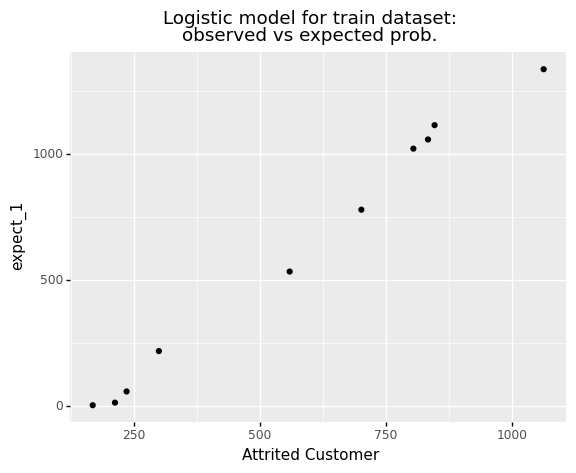

<ggplot: (8791520887229)>

In [90]:
# calculate H-L stat and p-value
hl_stat = hl_pivotframe['HL'].sum()
p_value = 1 - stats.chi2.cdf(hl_stat, 8)
print('H-L = {}\np-value = {}'.format(hl_stat, p_value))


ggplot(hl_pivotframe) +\
    geom_point(aes(x='Attrited Customer', y='expect_1')) +\
    labs(title='Logistic model for train dataset:\nobserved vs expected prob.')
    

In [91]:
# Checking Overdispersion 
print('estimated phi_hat : {}'.format(model1.pearson_chi2/model1.df_resid))


estimated phi_hat : 0.972160377191735


In [92]:
# Finalize Model
lr_model = model2

In [93]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                             Generalized Linear Model Regression Results                                              
======================================================================================================================================
Dep. Variable:     ['Attrition_Flag[Attrited Customer]', 'Attrition_Flag[Existing Customer]']   No. Observations:                12883
Model:                                                                                    GLM   Df Residuals:                    12878
Model Family:                                                                        Binomial   Df Model:                            4
Link Function:                                                                          logit   Scale:                          1.0000
Method:                                                                                  IRLS   Log-Likelihood:                -3632.9
Date:                                                                        Tue, 06 Jul 2021   Deviance:                       7265.8
Time:                                                                                07:22:45   Pearson chi2:                 8.22e+03
No. Iterations:                                                                             7                                         
Covariance Type:                                                                    nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Total_Trans_Ct_Binning_woe         -1.0395      0.035    -30.106      0.000      -1.107      -0.972
Total_Trans_Amt_Binning_woe        -0.6673      0.037    -18.232      0.000      -0.739      -0.596
Total_Revolving_Bal_Binning_woe    -1.7080      0.041    -41.936      0.000      -1.788      -1.628
Total_Ct_Chng_Q4_Q1_Binning_woe    -0.8764      0.036    -24.436      0.000      -0.947      -0.806
Months_Inactive_12_mon_woe         -1.7067      0.060    -28.602      0.000      -1.824      -1.590
===================================================================================================
"""

### Evaluation

In [94]:
y_test = y_test.replace({'Attrited Customer':1, 'Existing Customer':0})

In [95]:
# remove Avg_Utilization_Ratio_Binning_woe
X_test = X_test.drop(columns='Avg_Utilization_Ratio_Binning_woe')
X_test.head()

,Total_Trans_Ct_Binning_woe,Total_Trans_Amt_Binning_woe,Total_Revolving_Bal_Binning_woe,Total_Ct_Chng_Q4_Q1_Binning_woe,Months_Inactive_12_mon_woe
9242,2.836172,0.390575,0.347972,0.830295,1.406786
7036,1.408648,3.084464,-1.151760,0.830295,-0.800551
914,-1.124281,-0.522866,0.347972,0.411585,1.406786
9681,2.836172,0.390575,0.347972,0.830295,-0.356911
9026,1.408648,0.390575,0.347972,0.411585,-0.356911


In [96]:
# predict
y_pred = lr_model.predict(X_test)


In [97]:
threshold = 0.5
prediction = (y_pred > threshold).values.astype('int')

Text(0.5, 1.0, 'Confusion Matrix using LR\n                F1 : 0.58\n                Precision : 0.45\n                Recall : 0.83')

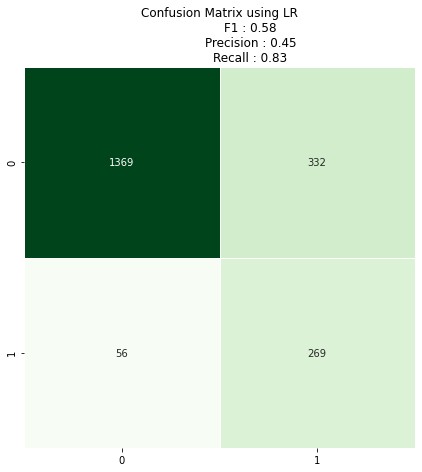

In [98]:
# confusion matrix
cm = confusion_matrix(y_test, prediction)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='Greens') 

fig = plt.figure(figsize=(7, 7))

ax = sns.heatmap(cm, annot=True, fmt='d', 
                 cbar=False, cmap='Greens', linewidth=0.5)
ax.set_title('Confusion Matrix using LR\n\
                F1 : {}\n\
                Precision : {}\n\
                Recall : {}'.format(np.round(f1_score(y_test, prediction),2), 
                                   np.round(precision_score(y_test, prediction),2), 
                                   np.round(recall_score(y_test, prediction),2)))




In [99]:
print('Accuracy of lr_model : {}'.format(accuracy_score(y_test, prediction)))
print('F1 Score of lr_model : {}'.format(f1_score(y_test, prediction)))
print('Precision of lr_model : {}'.format(precision_score(y_test, prediction)))
print('Recall of lr_model : {}'.format(recall_score(y_test, prediction)))

Accuracy of lr_model : 0.8084896347482725
F1 Score of lr_model : 0.5809935205183585
Precision of lr_model : 0.4475873544093178
Recall of lr_model : 0.8276923076923077


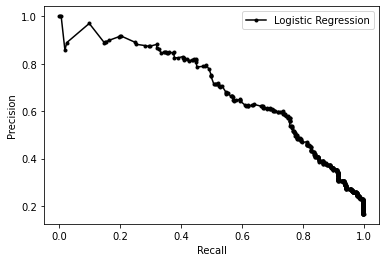

In [100]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, marker='.', c='black', label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


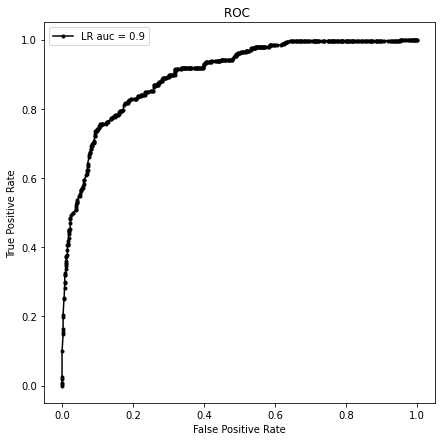

In [101]:
# roc-auc
lr_auc = np.round(roc_auc_score(y_test, y_pred), 2)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(7, 7))
plt.plot(lr_fpr, lr_tpr, marker='.', c='black', label='LR auc = {}'.format(lr_auc))

plt.title('ROC ')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


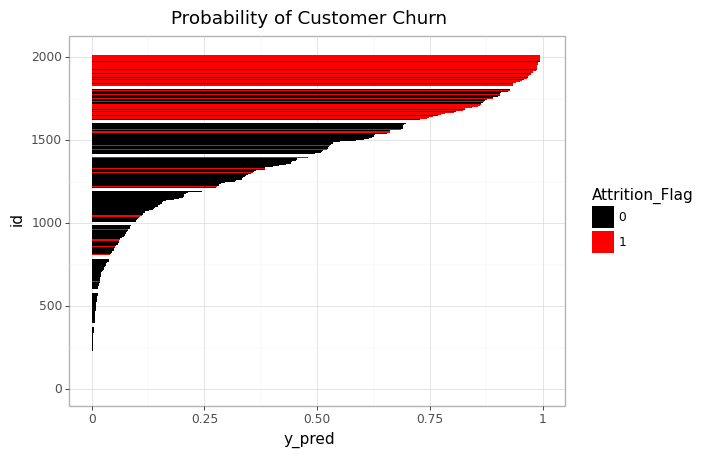

<ggplot: (8791520592117)>

In [102]:
tmp = pd.DataFrame({'Attrition_Flag':y_test, 
                   'y_pred':y_pred})
tmp = tmp.sort_values('y_pred').reset_index(drop=True)
tmp['id'] = [*range(1, tmp.shape[0]+1)]
tmp['Attrition_Flag'] = tmp['Attrition_Flag'].astype('str')
# tmp.head()

ggplot(tmp) +\
    geom_col(aes(x='id', y='y_pred', fill='Attrition_Flag')) +\
    labs(title='Probability of Customer Churn') +\
    coord_flip() +\
    scale_fill_manual(values = ("black", "red")) +\
    theme_light()
    
# theme(axis_title_y = element_blank()) +\

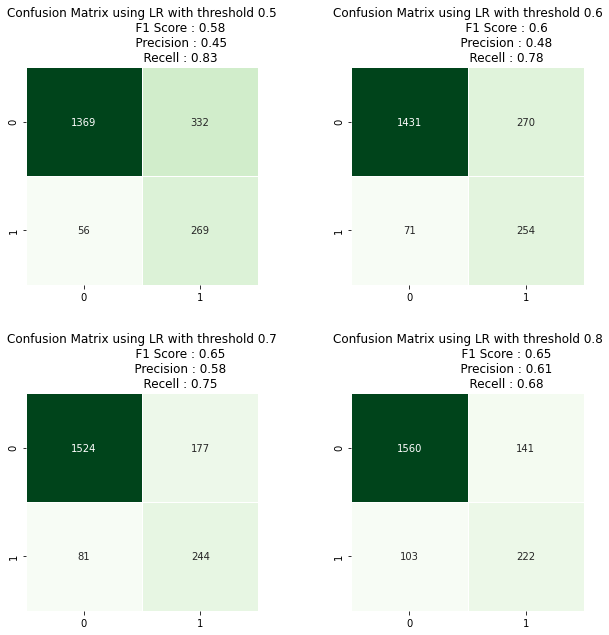

In [103]:
# Threshold Comparison : 0.5, 0.6, 0.7, 0.8


thresholds = [0.5, 0.6, 0.7, 0.8]

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
for i,thr in enumerate(thresholds):
    prediction = (y_pred > thr).values.astype('int')
    cm = confusion_matrix(y_test, prediction)
    
    ax = fig.add_subplot(2, 2, i+1)
    ax = sns.heatmap(cm, annot=True, fmt='d', 
                    cbar=False, cmap='Greens', linewidth=0.5)
    ax.set_title('Confusion Matrix using LR with threshold {}\n\
                    F1 Score : {}\n\
                    Precision : {}\n\
                    Recell : {}'.format(thr, 
                                       np.round(f1_score(y_test, prediction),2), 
                                       np.round(precision_score(y_test, prediction),2), 
                                       np.round(recall_score(y_test, prediction),2)))
    